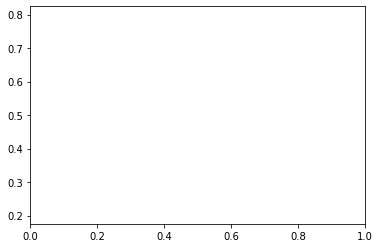

In [1]:
# Setup and import
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from math import *

plt.axes().set_aspect('equal', 'datalim')
plt.rcParams['figure.figsize'] = [15, 15]

AbaqusINP = 'Init_Trans'

In [2]:
# READ INITIAL INPUT FILE
# Function to extract nodal coordinates
def readINPUT(AbaqusINP):
    # Open file to read and write
    linesINP = open(AbaqusINP+".inp",'r')
    nodeInf = open(AbaqusINP+"NodeInf.txt",'w')
    
    # Read lines in initial input file and collect info
    for line in linesINP:
        if '*Node' in line:
            for line in linesINP:
                if '*Node' in line:
                    continue
                elif line.startswith('*Element, type=CPS4'): # It should be checked what types of element is used
                    linesINP.close()
                    nodeInf.close()
                    return

                nodeInf.write(line)

In [3]:
# Load Coordinates into NumPy Array
readINPUT(AbaqusINP)
coords = np.loadtxt(AbaqusINP+"NodeInf.txt", delimiter=',')

# Print to ensure the file was actually loaded
print(coords)

[[ 1.00000000e+00  1.80000000e+02  0.00000000e+00]
 [ 2.00000000e+00 -9.00019836e+01  1.55883423e+02]
 [ 3.00000000e+00  0.00000000e+00  0.00000000e+00]
 ...
 [ 1.27300000e+04  2.67511692e+01 -6.67773285e+01]
 [ 1.27310000e+04  2.99577618e+01 -6.70153503e+01]
 [ 1.27320000e+04  3.30236473e+01 -6.74877014e+01]]


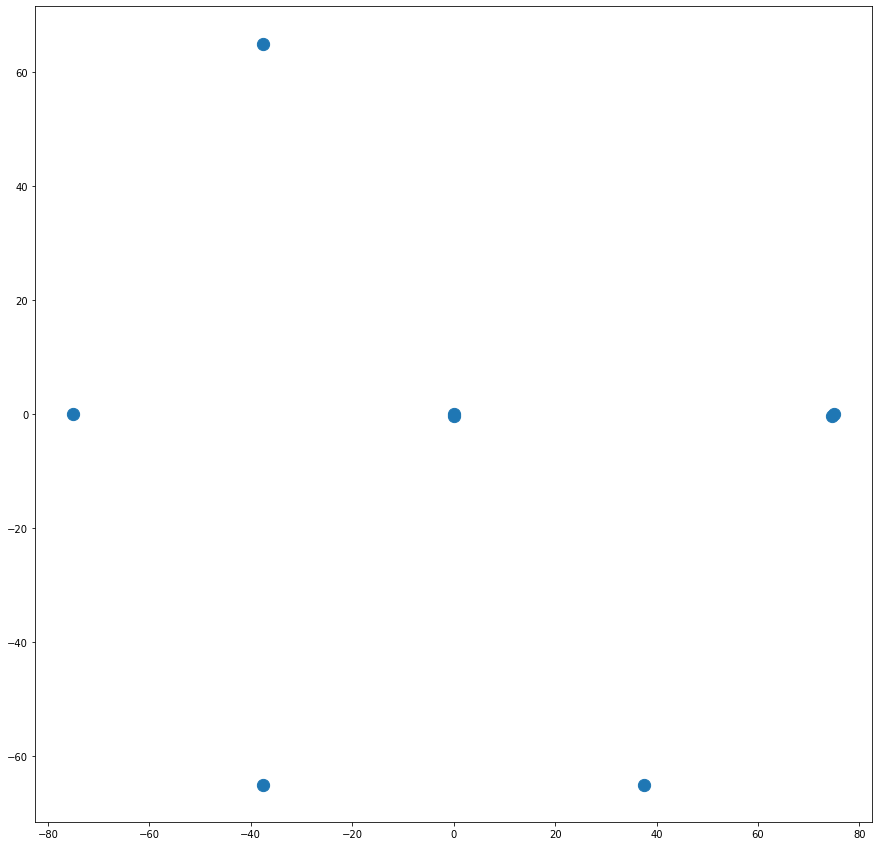

In [4]:
# Define Significant Points 
P1 = np.array([-37.5, -64.95])
P2 = np.array([-75., 0.])
P3 = np.array([-37.5, 64.95])
P4 = np.array([0., 0.])
P5 = np.array([75., 0.])
P6 = np.array([37.5, -64.95])
P7 = np.array([74.65, -0.25])
P8 = np.array([0., -0.25])


# Plot points to ensure accuracy
x1, y1 = np.array([P1, P2, P3, P4, P5, P6, P7, P8]).T
plt.scatter(x1, y1, s = 150)


In [5]:
# Initialize lists
inside = [] #For plotting
outside = [] #For plotting
fix = [] #For updating input file
free = [] # For pulling info from abaqus files

#Iterate through coordinates
for coord in coords:
    # Grab a coordinate
    xi, yi = float(coord[1]), float(coord[2])
    edge = np.linalg.norm(np.array([0., 0.])-np.array([xi, yi]))
    if abs(edge - 180.) >= 0.1: 
        inside.append([xi, yi])
        free.append(coord[0])
    else:
        outside.append([xi, yi])
        fix.append(coord[0])
    

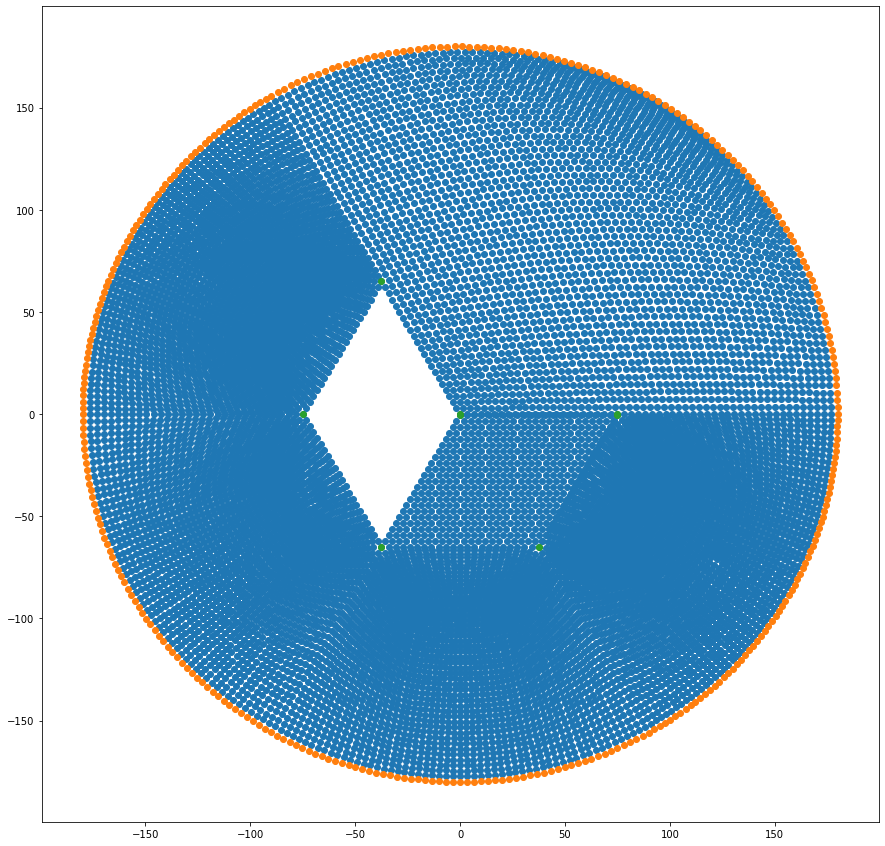

In [6]:
# Plot fixed points in orange and unfixed points in blue to confirm accuracy
# Also plot both sets of points of interest
x, y = np.array(inside).T
xout, yout =np.array(outside).T
plt.scatter(x, y)
plt.scatter(xout, yout)
plt.scatter(x1, y1)


In [7]:
# Output free nodes to a text file - used to collect info from abaqus outputs
with open('trans60_12500.txt', 'w') as f:
    for n in free:
        f.write("%d\n" % n)
        
# Also write all the nodes
with open('trans60_12500_all.txt', 'w') as f:
    for i in range(1, len(coords) + 1):
        f.write("%d\n" % i) 

In [8]:
# LOCATE THE EDGES OF THE FLAP GEOMETRY FOR STITCHING
# Initialize all sets
leftLINE_x, leftLINE_y = [], []
rightLINE_x, rightLINE_y = [], []
leftLINE_node, rightLINE_node = [], []

line12_x, line12_y, line12_node = [], [], []
line23_x, line23_y, line23_node = [], [], []
line34_x, line34_y, line34_node = [], [], []
line45_x, line45_y, line45_node = [], [], []
line56_x, line56_y, line56_node = [], [], []
line67_x, line67_y, line67_node = [], [], []
line78_x, line78_y, line78_node = [], [], []
line81_x, line81_y, line81_node = [], [], []

for coord in coords:
    # Grab a coordinate
    nodei, xi, yi = float(coord[0]), float(coord[1]), float(coord[2])

    # Form line12
    points = [P1,P2]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords)[0]
    line12 = m * xi + c
    
    # See if point is on line12
    if xi >= P2[0] and xi < P1[0] and abs(line12-yi) <= 0.1:
        line12_x.append(xi)
        line12_y.append(yi)
        line12_node.append(nodei)
        continue
        
    # Form line 23
    points = [P2,P3]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords)[0]
    line23 = m * xi + c
    
    # See if point is on line23
    if xi > P2[0] and xi <= P3[0] and abs(line23-yi) <= 0.1:
        line23_x.append(xi)
        line23_y.append(yi)
        line23_node.append(nodei)
        continue
        
    # Form line 34
    points = [P3,P4]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords)[0]
    line34 = m * xi + c
    
    # See if point is on line34
    if xi > P3[0] and xi <= P4[0] and abs(line34-yi) <= 0.1:
        line34_x.append(xi)
        line34_y.append(yi)
        line34_node.append(nodei)
        continue
        
    # See if point is on line45
    if xi > P4[0] and xi < P5[0] and abs(yi) <= 0.01:
        line45_x.append(xi)
        line45_y.append(yi)
        line45_node.append(nodei)
        continue
      
    # Form line 56
    points = [P5,P6]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords)[0]
    line56 = m * xi + c
    
    # See if point is on line56
    if xi < P5[0] and xi > P6[0] and abs(line56-yi) <= 0.001:
        line56_x.append(xi)
        line56_y.append(yi)
        line56_node.append(nodei)
        continue
        
    # form line 67
    points = [P6,P7]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords)[0]
    line67 = m * xi + c
    
    # See if point is on line67
    if xi >= P6[0] and xi < P7[0] and abs(line67-yi) <= 0.01:
        line67_x.append(xi)
        line67_y.append(yi)
        line67_node.append(nodei)
        continue

    # See if point is on line78
    if xi <= P7[0] + 0.1 and xi > P8[0] and abs(yi+0.25) <= 0.01:
        line78_x.append(xi)
        line78_y.append(yi)
        line78_node.append(nodei)
        continue
        
    # Form line 81
    points = [P8,P1]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords)[0]
    line81 = m * xi + c
    
    # See if point is on line 81
    if xi > P1[0] and xi <= P8[0] and abs(line81-yi) <= 0.1:
        line81_x.append(xi)
        line81_y.append(yi)
        line81_node.append(nodei)
        continue
        

C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`

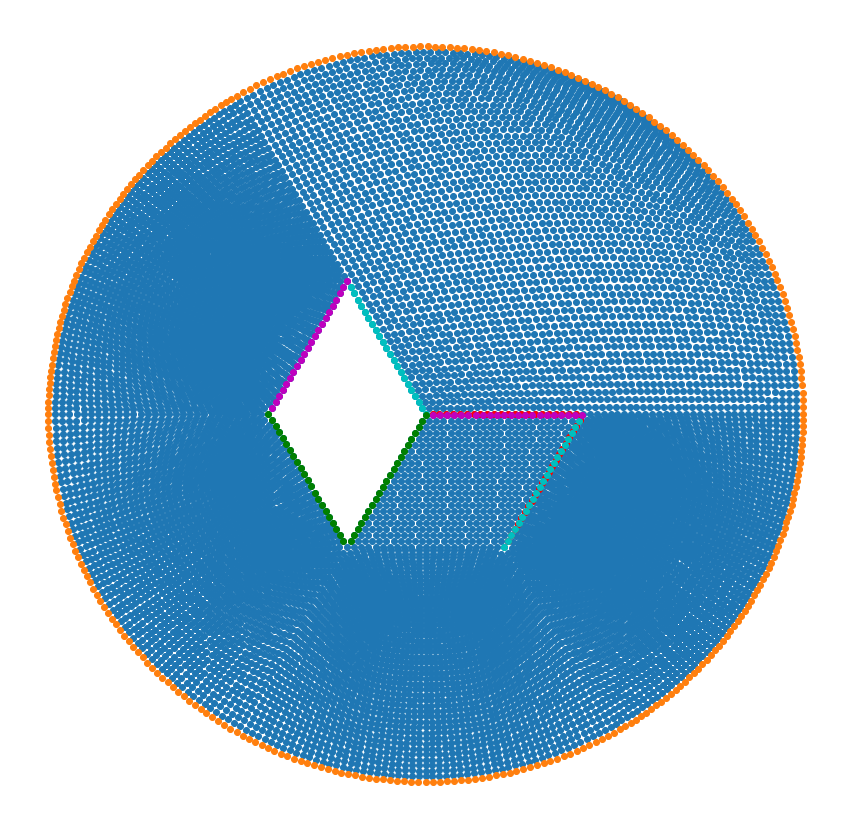

In [9]:
# Plot the results of the stitch points
plt.scatter(x, y)
plt.scatter(xout, yout)
plt.scatter(line12_x, line12_y, c='g')
plt.scatter(line23_x, line23_y, c='m')
plt.scatter(line34_x, line34_y, c='c')
plt.scatter(line45_x, line45_y, c='r')
plt.scatter(line56_x, line56_y, c='r')
plt.scatter(line67_x, line67_y, c='c')
plt.scatter(line78_x, line78_y, c='m')
plt.scatter(line81_x, line81_y, c='g')
plt.axis('off')
plt.savefig('transposition_schematic.png', format='png')

In [10]:
# Pair nodes for stitching
# Function to do this for line and circle segments
def pairStitches(iNode, oNode, innerx, innery, outerx, outery, segment):
    distances = []
    stitchO = []
    stitchI = []
    
    # Segment for sorting one edge in reverse order
    if (segment == 'inc_dec'):
        # Sort the edges
        oNode = [x for _,x in sorted(zip(outerx,oNode))]
        outery = [x for _,x in sorted(zip(outerx,outery))]
        outerx = sorted(outerx)

        iNode = [x for _,x in sorted(zip(innerx,iNode))]
        innery = [x for _,x in sorted(zip(innerx,innery))]
        innerx = sorted(innerx)
        # Reverse one edge
        iNode.reverse()
        innery.reverse()
        innerx.reverse()
        
        # Make pairs
        for i in range(0, len(oNode)):
            stitchO.append(oNode[i])
            stitchI.append(iNode[i])
            distances.append(sqrt((outerx[i] - innerx[i])**2. + (outery[i] - innery[i])**2.))
        
    # Segment for both edges sorted increasing x
    elif (segment == 'inc_inc'):
        # Sort
        oNode = [x for _,x in sorted(zip(outerx,oNode))]
        outery = [x for _,x in sorted(zip(outerx,outery))]
        outerx = sorted(outerx)

        iNode = [x for _,x in sorted(zip(innerx,iNode))]
        innery = [x for _,x in sorted(zip(innerx,innery))]
        innerx = sorted(innerx)
        
        # Make pairs
        for i in range(0, len(oNode)):
            stitchO.append(oNode[i])
            stitchI.append(iNode[i])
            distances.append(sqrt((outerx[i] - innerx[i])**2. + (outery[i] - innery[i])**2.))
        
    # Check your spelling
    else:
        print('That segment doesnt exist')
        
    return [stitchO, stitchI, distances]


# Do the pairing
[stitchO_A, stitchI_A, distances_A] = pairStitches(line81_node, line12_node, line81_x, line81_y, line12_x, line12_y, 'inc_dec')
[stitchO_B, stitchI_B, distances_B] = pairStitches(line23_node, line78_node, line23_x, line23_y, line78_x, line78_y, 'inc_inc')
[stitchO_C, stitchI_C, distances_C] = pairStitches(line34_node, line67_node, line34_x, line34_y, line67_x, line67_y, 'inc_dec')
[stitchO_D, stitchI_D, distances_D] = pairStitches(line45_node, line56_node, line45_x, line45_y, line56_x, line56_y, 'inc_inc')

# Make a set of all the pairs
stitchO = np.concatenate((stitchO_A, stitchO_B, stitchO_C, stitchO_D))
stitchI = np.concatenate((stitchI_A, stitchI_B, stitchI_C, stitchI_D))
distances = np.concatenate((distances_A, distances_B, distances_C, distances_D))


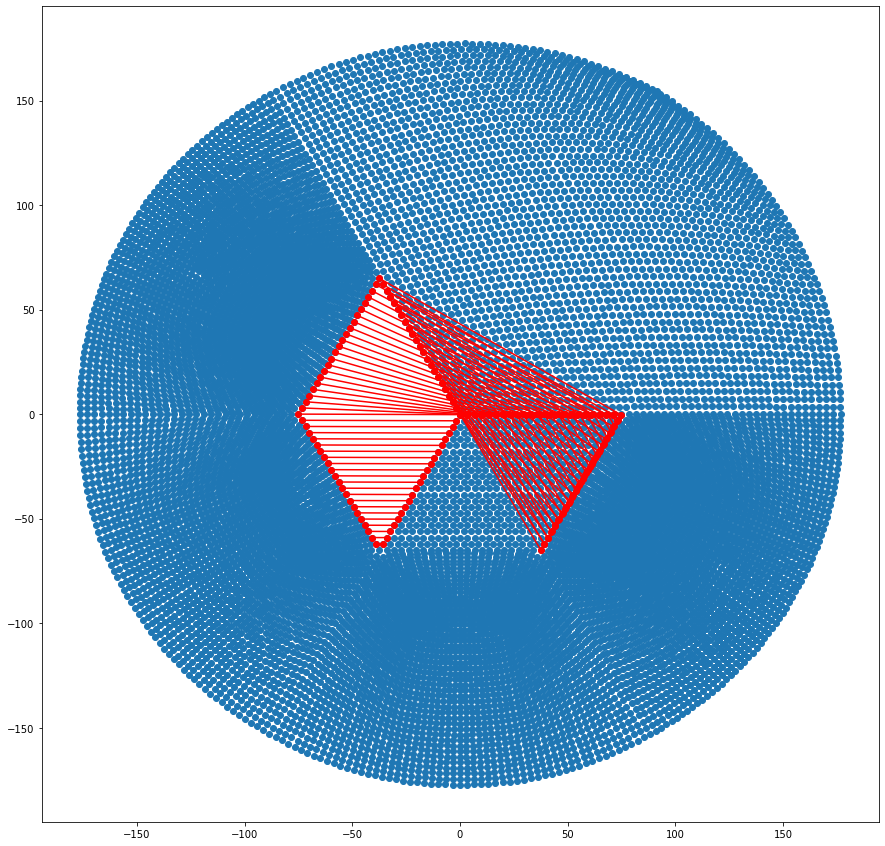

In [11]:
plt.scatter(x, y)
for i in range(0, len(stitchO)):
    plt.plot([coords[int(stitchO[i]) - 1][1],  coords[int(stitchI[i]) - 1][1]], [coords[int(stitchO[i]) - 1][2],  coords[int(stitchI[i]) - 1][2]], 'ro-')

In [12]:
# WRITE TO THE NEW INPUT FILE
# Open and read in base input file
linesINP = open(AbaqusINP+".inp",'r')
i = 0
lines = []
for line in linesINP:
    lines.append(line)
    if line == '*End Part\n':
        endPart = i
    i += 1

# Close base inputs file
linesINP.close()

In [13]:
# Determine how many nodes and elements you have
for i in range(0, len(lines)):
    if lines[i][0:8] == '*Element':
        break
n_nodes = int(lines[i-1].strip().split(',')[0])

# Get total number of elements
for i in range(0, len(lines)):
    if lines[i] == '*End Part\n':
        break
n_elems_1 = int(lines[i-1].strip().split(',')[0])

for i in range(0, len(lines)):
    if lines[i] == '*Element, type=CPS3\n':
        break
n_elems_2 = int(lines[i-1].strip().split(',')[0])

n_elems = max(n_elems_1, n_elems_2)

# Confirm you got the right numbers
print(n_elems)
print(n_nodes)

# Build overall node and element sets
sets = ['*Nset, nset=Set-1, generate\n']
sets.append('1,'+str(n_nodes) + ', 1\n')
sets.append('*Elset, elset=SKIN_element, generate\n')
sets.append('1,'+str(n_elems) + ', 1\n')

# Insert the new lines, adjusting i to know where the end of the files is
i = endPart
for set in sets:
    lines.insert(i, set)
    i += 1

12473
12732


In [14]:
# Add material parameters for skin
# Define these lines
skinParams = ['**\n', 
              '*ORIENTATION, NAME=ORI\n', 
              '-0.9885573278588885, 0.15084564805288259, 0., -0.15084564805288259, -0.9885573278588885, 0.\n', 
              '3, 0.\n', 
              '*SOLID SECTION, ELSET=SKIN_element, MATERIAL=SKIN_HOLZ, ORIENTATION=ORI\n']

# Add these parameters, again adjusting i
for param in skinParams:
    lines.insert(i, param)
    i += 1

In [15]:
# Create connectors for stitches
instname = 'transflap-1'

# Locate the end of the assembly
for i in range(0, len(lines)):
    if lines[i] == '*End Assembly\n':
        endAssem = i
        print(endAssem)
        break
        
# Initialize the connector set
connectors = ['**\n', '*Element, type=CONN2D2\n']

# Use the overall stitching sets to create the connectors
for i in range(0, len(stitchO)):
   connectors.append(str(i+1) + ', ' + instname + '.' + str(int(stitchO[i])) + ', ' + instname + '.' + str(int(stitchI[i])) + '\n')

# Adjust i
i = endAssem - 1
for conn in connectors:
    lines.insert(i, conn)
    i += 1

# Create a section for the connectors
lines.insert(i, '*Connector Section, elset=Set-2\n')
lines.insert(i+1, 'Axial,\n')

25235


In [16]:
#Create node set for skin
for i in range(0, len(lines)):
    if lines[i] == 'Axial,\n':
        endConSec = i
        break
nset = ['*Nset, nset=SKINNODE, instance=' + instname + '\n']

# Add lines for this node set, putting 15 nodes per line
j = 0
nline = ' '
for i in range(1, len(coords)+1, 1):
    if j == 15 or i == len(coords):
        nline = nline + str(i) + '\n'
        nset.append(nline)
        j = 1
        nline = ' '
    else:
        nline = nline + str(i) + ', '
        j += 1

# Add lines
i = endConSec + 1
for n in nset:
    lines.insert(i, n)
    i += 1

In [17]:
# Create wire sets for the stitches
# Figure out where the node set ends
for i in range(0, len(lines)):
    if lines[i] == nset[-1]:
        endNset = i
        break
        
# Create wires, similar to connectors
wires = []
for i in range(0, len(stitchO)):
    wires.append('*Nset, nset=WIRE-' + str(i+1) + ', instance=' + instname + '\n')
    wires.append(' ' + str(int(stitchO[i])) + ', ' + str(int(stitchI[i])) + '\n')

# Add lines
i = endNset + 1
for wire in wires:
    lines.insert(i, wire)
    i += 1


In [18]:
# Create node set for fixed nodes
# Figure out where the wires end
for i in range(0, len(lines)):
    if lines[i] == wires[-1]:
        endWires = i
        break

# Write out node set, 15 nodes per line
nset = ['*Nset, nset=fix, internal, instance=' + instname + '\n']
fix = sorted(fix)
j = 0
nline = ' '
for i in range(0, len(fix), 1):
    if j == 15 or i == len(fix)-1:
        nline = nline + str(int(fix[i])) + '\n'
        nset.append(nline)
        j = 1
        nline = ' '
    else:
        nline = nline + str(int(fix[i])) + ', '
        j += 1

# Add to the file
i = endWires + 1
for n in nset:
    lines.insert(i, n)
    i += 1

In [19]:
# Create element sets 
for i in range(0, len(lines)):
    if lines[i] == nset[-1]:
        endSet = i
        break

# Initialize element set
elSet = ['*Elset, elset=Set-2, internal, generate\n']
elSet.append('1, ' + str(int(len(distances))) + ', 1\n') 

# Add for each stitch
n = 1
for i in range(1, len(distances)+1):
    elSet.append('*Elset, elset=_PickedSet'+str(int(n))+', internal\n')
    elSet.append(' ' + str(int(i))+',\n')
    n += 1
    
# Add to file
i = endSet + 1
for el in elSet:
    lines.insert(i, el)
    i+=1

In [20]:
# Add material parameters
matParams = ['**\n', 
             '** MATERIALS\n',
             '**\n',
             '*Material, name=SKIN_HOLZ\n',
             '*Anisotropic Hyperelastic, holzapfel, local direction=1\n',
             '0.051376, 0.0005, 21.157203, 60.480896, 0.252729\n',
             '**22.49,  0.0005, 4909.2,  76.641,  0.1\n',
             '** C10, D, k1, k2, kappa\n',
             '**DISTRIBUTION TABLE, NAME=DISTORI_TABLE\n',
             '**COORD3D,COORD3D\n',
             '**DISTRIBUTION TABLE, NAME=ANGLETABLE\n',
             '**ANGLE\n']
for param in matParams:
    lines.append(param)
             

In [21]:
# Boundary conditions - Fix nodes
fixConditions = ['**\n',
                 '**BOUNDARY CONDITIONS\n',
                 '**\n',
                 '** Name: fixednodes Type: Symmetry/Antisymmetry/Encastre\n'
                '*BOUNDARY\n',
                'fix, ENCASTRE\n',
                '**\n']
for condition in fixConditions:
    lines.append(condition)

In [22]:
# Boundary conditions - Step 1 
step_1 = ['**\n',
         '** ----------------------------------------------------------------\n',
         '**\n',
         '** STEP: Step-1\n',
         '**\n',
         '*Step, name=Step-1, nlgeom=YES, inc=1000\n',
         '*Static\n',
         '0.1, 1., 1e-07, 1.\n',
         '**\n',
         '**BOUNDARY CONDITIONS\n',
         '**\n']

# Define displacements
n = 1
for i in range(len(distances_A)):
    step_1.append('** Name: ConnDisp-BC-'+ str(int(n)) + ' Type: Connector displacement\n')
    step_1.append('*Connector Motion\n')
    step_1.append('_PickedSet'+str(int(n))+', 1, -'+str(floor(distances[i]*10)/10)+'\n') #FIXME added the - 0.1
    n+=1
endN = n
 
# Add to file
for line in step_1:
    lines.append(line)
    
# Request outputs 
outputs = ['**\n',
           '** OUTPUT REQUESTS\n',
           '**\n',
           '*Restart, write, frequency=0\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-1\n',
           '**\n',
           '*Output, field\n',
           '*Contact Output\n',
           'CDISP, CSTRESS\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-2\n',
           '**\n',
           '*Node Output\n',
           'CF, COORD, RF, U\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-3\n',
           '**\n',
           '*Element Output, directions=YES\n',
           'EVOL, IVOL, LE, PE, PEEQ, PEMAG, S, SVOL\n',
           '**\n',
           '** HISTORY OUTPUT: H-Output-1\n',
           '**\n',
           '*Output, history, variable=PRESELECT\n',
           '*End Step\n']
for output in outputs:
    lines.append(output)


In [23]:
# Boundary conditions - step 2
step_2 = ['**\n',
         '** ----------------------------------------------------------------\n',
         '**\n',
         '** STEP: Step-2\n',
         '**\n',
         '*Step, name=Step-2, nlgeom=YES, inc=1000\n',
         '*Static\n',
         '0.1, 1., 1e-07, 1.\n',
         '**\n',
         '**BOUNDARY CONDITIONS\n',
         '**\n']

# Define displacements
n = endN
for i in range(len(distances_B)):
    step_2.append('** Name: ConnDisp-BC-'+ str(int(n)) + 'Type: Connector displacement\n')
    step_2.append('*Connector Motion\n')
    step_2.append('_PickedSet'+str(int(n))+', 1, -'+str(floor(distances[n-1]*10)/10)+'\n')
    n+=1
endN = n

# Add to file
for line in step_2:
    lines.append(line)
    
# Output requests
outputs = ['**\n',
           '** OUTPUT REQUESTS\n',
           '**\n',
           '*Restart, write, frequency=0\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-4\n',
           '**\n',
           '*Output, field\n',
           '*Contact Output\n',
           'CDISP, CSTRESS\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-5\n',
           '**\n',
           '*Node Output\n',
           'CF, COORD, RF, U\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-6\n',
           '**\n',
           '*Element Output, directions=YES\n',
           'EVOL, IVOL, LE, PE, PEEQ, PEMAG, S, SVOL\n',
           '**\n',
           '** HISTORY OUTPUT: H-Output-2\n',
           '**\n',
           '*Output, history, variable=PRESELECT\n',
           '*End Step\n']
for output in outputs:
    lines.append(output)

In [24]:
# Boundary conditions - Step 3
step_3 = ['**\n',
         '** ----------------------------------------------------------------\n',
         '**\n',
         '** STEP: Step-3\n',
         '**\n',
         '*Step, name=Step-3, nlgeom=YES, inc=1000\n',
         '*Static\n',
         '0.1, 1., 1e-07, 1.\n',
         '**\n',
         '**BOUNDARY CONDITIONS\n',
         '**\n']

# Define displacements
n = endN
for i in range(len(distances_C)):
    step_3.append('** Name: ConnDisp-BC-'+ str(int(n)) + 'Type: Connector displacement\n')
    step_3.append('*Connector Motion\n')
    step_3.append('_PickedSet'+str(int(n))+', 1, -'+str(floor(distances[n-1]*10)/10)+'\n')
    n+=1
endN = n

# Add to file
for line in step_3:
    lines.append(line)
    
# Output requests
outputs = ['**\n',
           '** OUTPUT REQUESTS\n',
           '**\n',
           '*Restart, write, frequency=0\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-4\n',
           '**\n',
           '*Output, field\n',
           '*Contact Output\n',
           'CDISP, CSTRESS\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-5\n',
           '**\n',
           '*Node Output\n',
           'CF, COORD, RF, U\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-6\n',
           '**\n',
           '*Element Output, directions=YES\n',
           'EVOL, IVOL, LE, PE, PEEQ, PEMAG, S, SVOL\n',
           '**\n',
           '** HISTORY OUTPUT: H-Output-2\n',
           '**\n',
           '*Output, history, variable=PRESELECT\n',
           '*End Step\n']
for output in outputs:
    lines.append(output)

In [25]:
# Boundary conditions - Step 4
step_4 = ['**\n',
         '** ----------------------------------------------------------------\n',
         '**\n',
         '** STEP: Step-4\n',
         '**\n',
         '*Step, name=Step-4, nlgeom=YES, inc=1000\n',
         '*Static\n',
         '0.1, 1., 1e-07, 1.\n',
         '**\n',
         '**BOUNDARY CONDITIONS\n',
         '**\n']

# Define displacements
n = endN
for i in range(len(distances_D)):
    step_4.append('** Name: ConnDisp-BC-'+ str(int(n)) + 'Type: Connector displacement\n')
    step_4.append('*Connector Motion\n')
    step_4.append('_PickedSet'+str(int(n))+', 1, -'+str(floor(distances[n-1]*10)/10 - 0.1)+'\n')
    n+=1
endN = n

# Add to file
for line in step_4:
    lines.append(line)
    
# Output requests
outputs = ['**\n',
           '** OUTPUT REQUESTS\n',
           '**\n',
           '*Restart, write, frequency=0\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-4\n',
           '**\n',
           '*Output, field\n',
           '*Contact Output\n',
           'CDISP, CSTRESS\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-5\n',
           '**\n',
           '*Node Output\n',
           'CF, COORD, RF, U\n',
           '**\n',
           '** FIELD OUTPUT: F-Output-6\n',
           '**\n',
           '*Element Output, directions=YES\n',
           'EVOL, IVOL, LE, PE, PEEQ, PEMAG, S, SVOL\n',
           '**\n',
           '** HISTORY OUTPUT: H-Output-2\n',
           '**\n',
           '*Output, history, variable=PRESELECT\n',
           '*End Step\n']
for output in outputs:
    lines.append(output)

In [26]:
# Write new input file
with open('Base_Transposition.inp', 'w') as f:
    for line in lines:
        f.write("%s" % line)